In [1]:
import os
import random
%load_ext autoreload
%autoreload 2
import pickle
import pandas as pd
%matplotlib inline
from matplotlib.ticker import FuncFormatter 
import matplotlib
import matplotlib.pyplot as plt
import glob
from pdb import set_trace
import json
import numpy as np
from scipy import stats

game_titles = {
        "shuffleKeys_game": "Shuffle Keys Game",
        "contingency_game": "Contingency Game",
        "logic_game": "Logic Game",
        "logic_extended_game": "Ext Logic",
    }

label_dict = { 'human': 'Human', 'self_class': 'Self Class', 'dqn_training': 'DQN',
                       'random': 'Random', 'a2c_training': "A2C", 'trpo_training': 'TRPO', 'ppo2_training':'PPO2',
               'acer_training': 'ACER'}

def ts_plotter(self, ax, data1, data2):
    '''
    Helper for plotting panels in time series plot.
    '''

    out = ax.plot(data1, data2, linewidth=2)
    return out

In [2]:
def get_performance(game_types, agent_types, y_lims, batch_size=10):
    ''' Plot performance for games and agents'''
    param_dict = {}

    ## ----- Read in data
    ext_data = []
    for i, game_type in enumerate(game_types):
        param_dict[game_type] = {}
        for agent_type in agent_types:
            files = glob.glob("../data/" + game_type + "/" + agent_type + "/*/*.json")
            if len(files) == 0:
                files = glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")

            seed = 0
            curr_file_count = 0
            param_dict[game_type][agent_type] = {}
            seed_current = []
            all_seeds = []
            for i, file in enumerate(sorted(files, key=os.path.getmtime)):
                with open(file, 'r') as fp:
                    if agent_type == 'human' and game_type == 'logic':  # TODO: change after we get data
                        f = open(file, 'rb')
                        param_dict[game_type][agent_type] = pickle.load(f)
                        continue

                    data = json.load(fp)

                    param_dict[game_type][agent_type] = data['data']['steps']
                    curr_file_count += 1

                    seed_current.append(data['data']['steps'])

                    if curr_file_count == 20:
                        all_seeds.append(seed_current)
                        seed_current = []
                        curr_file_count = 0
                        seed += 1

                    if seed == 10:
                        param_dict[game_type][agent_type] = all_seeds
                        all_seeds = []

    ## ---- Get descriptive statistics
    stats_dict = {}
    for game_type in game_types:
        stats_dict[game_type] = {}
        for agent_type in agent_types:
            curr_data = pd.DataFrame(param_dict[game_type][agent_type])

            seed_average = []
            for column in curr_data:
                seed_average.append(np.mean(list(curr_data[column]), axis=0))
            # TODO
            # curr_data = pd.concat([pd.DataFrame(seed_average).T, pd.DataFrame(ext_avg).T], ignore_index=True)
            curr_data = pd.DataFrame(seed_average).T
            stats_dict[game_type][agent_type] = curr_data
            if agent_type != 'human':
                stats_dict[game_type][agent_type + "_m"] = np.array(
                    [curr_data[column].groupby(curr_data.index // batch_size).mean() for column in curr_data]).reshape(
                    int(curr_data.shape[1] * 100 * 1 / batch_size))
                stats_dict[game_type][agent_type + "_se"] = np.array(
                    [curr_data[column].groupby(curr_data.index // batch_size).sem() for column in curr_data]).reshape(
                    int(curr_data.shape[1] * 100 * 1 / batch_size))
            else:
                stats_dict[game_type][agent_type + "_m"] = np.array(
                    [curr_data[column].groupby(curr_data.index // batch_size).mean() for column in curr_data]).reshape(
                    int(100 / batch_size))
                stats_dict[game_type][agent_type + "_se"] = np.array(
                    [curr_data[column].groupby(curr_data.index // batch_size).sem() for column in curr_data]).reshape(
                    int(100 / batch_size))

    ## ---- Plot data
    return stats_dict, game_types, agent_types, y_lims, batch_size


def plotter(stats, game_types, agent_types, y_lims, batch_size, combined=False):
    for i, game_type in enumerate(game_types):
        st = stats[game_type]

        fig, ax = plt.subplots(figsize=(20, 10))
        ax.xaxis.label.set_size(25)
        ax.yaxis.label.set_size(25)
        ax.set_xlabel(xlabel="Levels Played", labelpad=21)
        if combined:
            y_str = "No. of Steps to Complete Level ({} Level MA) \nGame modified after 2000 Level Boundary".format(
                batch_size)
        else:
            y_str = "No. of Steps to Complete Level ({} Level MA)".format(
                batch_size)
        ax.set_ylabel(ylabel=y_str, labelpad=21)
        ax.tick_params(axis='both', which='major', labelsize=17)
        ax.set_title(game_titles[game_type], fontweight='bold', fontsize=15)

        colors = ["#0373fc", "#d002f5", "#000000", "#fa0047", "#ff8903", "#03fc9d"]
        for i, agent_type in enumerate(agent_types):

            if agent_type != 'human':
                xs = [int(i * batch_size) for i in range(0, len(st[agent_type + "_m"]))]
                r_l = ax.plot(xs, st[agent_type + "_m"], color=colors[i], linewidth=1, label=label_dict[agent_type])
                x = [int(i * batch_size) for i in range(0, len(st[agent_type + "_m"]))]
                ax.fill_between(x, st[agent_type + "_m"] - st[agent_type + "_se"],
                                st[agent_type + "_m"] + st[agent_type + "_se"], alpha=0.08, color=colors[i])
            else:
                xs = [int(i * batch_size) for i in range(0, len(st["human_m"]) + 1)]
                hum_l = ax.plot(xs, np.append(st['human_m'], st['human_m'][1]), color=colors[i], linewidth=2,
                                label=label_dict['human'])
                x = [int(i * batch_size) for i in range(0, len(st["human_m"]) + 1)]
                ax.fill_between(x, np.append(st['human_m'] - st['human_se'], st['human_m'][1] - st['human_se'][1]),
                                np.append(st['human_m'] + st['human_se'], st['human_m'][1] + st['human_se'][1]),
                                alpha=0.08, color=colors[i])

        # first_legend = plt.legend(handles=[r_l[0], dqn_l[0], sc_l[0], hum_l[0]], loc='upper right', prop={'size': 22})
        if combined:
            plt.axvline(x=2000, color="#ffff03", alpha=0.2, linewidth=15)
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        plt.show()
        fig.savefig('effiency_curves_' + game_type + '.pdf', format='pdf')


# Append stats of two data (normal + extended)
def append_stats(dict_normal, dict_ext, game_types, game_types_ext, agent_types):
    appended_data = {}
    for i, game in enumerate(game_types):
        appended_data[game] = {}
        for agent in agent_types:
            for key, value in dict_normal[game].items():
                data_normal = dict_normal[game][key]
                data_ext = dict_ext[game_types_ext[i]][key]
                appended_data[game][key] = np.concatenate((data_normal, data_ext))

    return appended_data

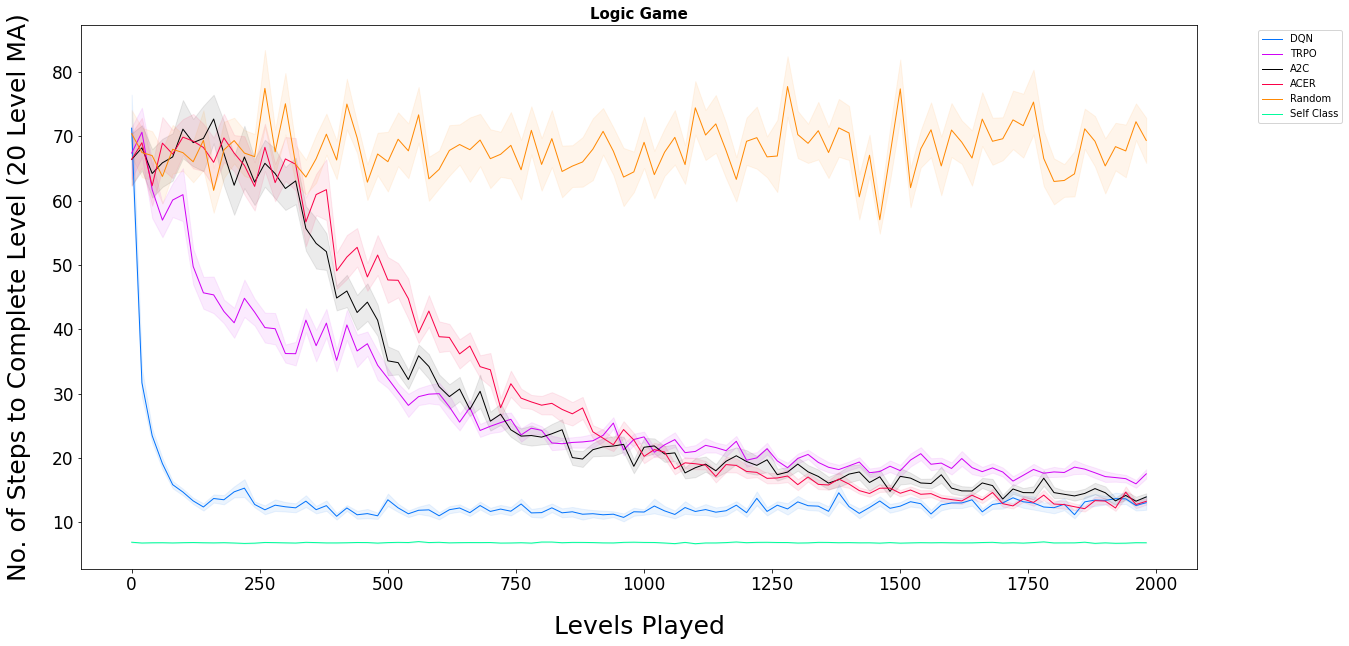

In [4]:
game_types = ["logic_game"]
agent_types = ["dqn_training", "trpo_training", "a2c_training", "acer_training", "random", "self_class"]
y_lims = [250, 2000, 2000]
batch_size = 20
stats_dict, game_types, agent_types, y_lims, batch_size = get_performance(game_types, agent_types, y_lims, batch_size)

# Get performance stats of extended game
game_types_ext = ["logic_extended_game"]
agent_types_ext = ["dqn_training", "trpo_training", "a2c_training", "acer_training"]
stats_dict_ext, game_types_ext, agent_types_ext, y_lims_ext, batch_size_ext = get_performance(game_types_ext,
                                                                                              agent_types_ext,
                                                                                              y_lims, batch_size)

plotter(stats_dict, game_types, agent_types, y_lims, batch_size, False)

#appended_stats = append_stats(stats_dict, stats_dict_ext, game_types, game_types_ext, agent_types)
#plotter(appended_stats, game_types, agent_types, y_lims, batch_size, True)


In [ ]:
## ----- Deeper dive into different DQN hyperparameters
def plot_dqns(directory, y_lims):

    param_folders = glob.glob(directory)
    param_dict = {}   
    ## ----- Read in data
    for folder in param_folders:
        folder_name = folder.split('/')[4]
        param_dict[folder_name] = {}
        files = glob.glob(folder + "/*.json")
        for file in files:
            with open (file, 'r') as fp: 
                data = json.load(fp)
                param_dict[folder_name][file.split('/')[5].split('.json')[0]] = data['data']['steps']

    ## ---- Get descriptive statistics
    stats2 = pd.DataFrame() #for stats
    stats2_keys = []
    for key in param_dict:
        curr_data = pd.DataFrame(param_dict[key])
        stats2[key + "_m"] = curr_data.mean(axis=1)
        stats2[key + "_se"] = curr_data.sem(axis=1)
        stats2_keys.append(key)

    stats2['x'] = [i for i in range(0, len(stats2[key + "_m"]))]   
    
    plotter2(stats2, y_lims, stats2_keys)
    
def plotter2(stats2, y_lims, stats2_keys):
        ## --- Plot descriptive statistics
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_ylim([0, 50]) #13 or 150
        ax.xaxis.label.set_size(25)
        ax.yaxis.label.set_size(25)
        ax.set_xlabel(xlabel="Levels Played", labelpad=21)
        ax.set_ylabel(ylabel="No. of Steps to Complete Level", labelpad=21)
        ax.tick_params(axis='both', which='major', labelsize=17)

        #colors = ['orange', 'blue', 'red', 'purple']
        colors = []
        handle_list = []

        key_counter = -1
        for key in stats2_keys:
            key_counter += 1
            #colors[key_counter] = random_color()
            handle = ax.plot(stats2[key + "_m"], linewidth=2, label=str(key))
            handle_list.append(handle[0])
            ax.fill_between(stats2['x'], stats2[key+"_m"] - stats2[key+"_se"], stats2[key+"_m"] + stats2[key+"_se"], alpha=0.08)

#        first_legend = plt.legend(handles=handle_list, loc='upper right', prop={'size': 22})    
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

        ## --- Bin data
        #stats_2 = stats_2.groupby(stats_2.index // 5).mean().reset_index()
        #stats_2['x'] = stats_2.index

In [ ]:
directory = "../data/test1_game/dqn_training/*"
#game_types = ["logic_game", "contingency_game", "shuffleKeys_game"]
y_lims = [50, 50, 50]
plot_dqns(directory, y_lims)

In [5]:
## ----- Plot the number of steps the player takes before any agent moves from its starting location

# Plot non-moving action count of agent for each level
def plot_nm_ac(game_types, agent_types, batch_size=20):
    for i, game_type in enumerate(game_types):
        nm_ac = get_all_nm_ac(agent_types, game_type, batch_size)

        fig, ax = plt.subplots(figsize=(20, 10))
        ax.set_ylim([0, 10])
        ax.xaxis.label.set_size(25)
        ax.yaxis.label.set_size(25)
        ax.set_xlabel(xlabel="Levels Played", labelpad=21)
        ax.set_ylabel(ylabel="Action Count Until Movement ({} Level MA)".format(batch_size), labelpad=21)
        ax.tick_params(axis='both', which='major', labelsize=17)
        game_label_dict = {'logic_game': "Logic Game"}
        ax.set_title( game_label_dict[game_type], fontweight='bold', fontsize=15 )

        colors = ["#0373fc", "#d002f5", "#000000", "#fa0047", "#ff8903", "#03fc9d"]
        agent_label_dict = {'dqn_training': 'DQN', 'human':"Human", "self_class": "Self Class", "random": "Random",
                            'a2c_training': "A2C", 'trpo_training': 'TRPO', 'ppo2_training':'PPO2', "acer_training": "ACER"}
        for j, agent in enumerate(agent_types):


            if agent == 'human':
                xs = [int(i * batch_size) for i in range(0, len(nm_ac[agent + "_m"]) + 1)]
                ax.plot( xs, np.append(nm_ac[agent + "_m"], nm_ac[agent + "_m"][1]), color=colors[j], linewidth=1, label=agent_label_dict[agent] )
                upper_curve = [nm_ac[agent + '_m'][i] + nm_ac[agent + '_se'][i] for i in range(len(nm_ac[agent + '_m']))]
                lower_curve = [nm_ac[agent + '_m'][i] - nm_ac[agent + '_se'][i] for i in range(len(nm_ac[agent + '_m']))]
                x = [int(i * batch_size) for i in range(0, len(nm_ac[agent + "_m"]) + 1)]
                ax.fill_between( x, np.append(lower_curve, lower_curve[1]), np.append(upper_curve, upper_curve[1]), alpha=0.08, color=colors[j] )
            else:
                xs = [int(i * batch_size) for i in range(0, len(nm_ac[agent + "_m"]))]
                ax.plot( xs, nm_ac[agent + "_m"], color=colors[j], linewidth=1, label=agent_label_dict[agent] )
                upper_curve = [nm_ac[agent + '_m'][i] + nm_ac[agent + '_se'][i] for i in range(len(nm_ac[agent + '_m']))]
                lower_curve = [nm_ac[agent + '_m'][i] - nm_ac[agent + '_se'][i] for i in range(len(nm_ac[agent + '_m']))]
                x = [int(i * batch_size) for i in range(0, len(nm_ac[agent + "_m"]))]
                ax.fill_between( x, lower_curve, upper_curve, alpha=0.08, color=colors[j] )

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        
        fig.savefig('no_movement_action_count.pdf', format='pdf')

# # Get non-moving action count of agent for each level and each game as a dictionary
def get_all_nm_ac(agent_types, game_type, batch_size):

    stats = {}
    for agent in agent_types:
        stats[agent + "_m"], stats[agent + "_se"] = get_nm_ac(agent, game_type, batch_size)
        
    return stats

# Get non-moving action count of agent for each level
def get_nm_ac(agent_type, game_type, batch_size):

    files = glob.glob("../data/" + game_type + "/" + agent_type + "/*/*.json")

    if len(files) == 0:
        files = glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")



    # Iterate through each file
    # TODO: Divide each seed and get SEM

    all_seeds = []
    curr_seed = []
    seed = 0
    curr_file_count = 0
    for i, file in enumerate(sorted(files, key=os.path.getmtime)):
        data = json.load(open(file))
        self_locs = data.get("data")["self_locs"]

        level_amt = 100
        action_count = [1] * level_amt

        # In each 100 levels:
        for level in range(level_amt):
            if len( self_locs[level] ) == 0:
                continue
            action_amt = len(self_locs[level][0])
            for i in range( action_amt ):
                if i == level_amt:
                    break

                x = self_locs[level][0][i]
                y = self_locs[level][1][i]
                x1 = self_locs[level][0][i + 1]
                y1 = self_locs[level][1][i + 1]

                if x == x1 and y == y1: # Still in the same position
                    action_count[level] = action_count[level] + 1
                else: # Position have changed
                    break

        curr_file_count += 1
        curr_seed.append(action_count)

        if curr_file_count == 20:
            all_seeds.append(curr_seed)
            curr_seed = []
            curr_file_count = 0
            seed += 1

    seed_average = []
    all_seeds = pd.DataFrame(all_seeds)
    for column in all_seeds:
        seed_average.append(np.mean(list(all_seeds[column]), axis=0))

    all_seeds = pd.DataFrame(seed_average).T

    seed_mean = np.array([all_seeds[column].groupby(all_seeds.index // batch_size).mean() for column in all_seeds]).reshape(int(all_seeds.shape[1] * 100 * 1/batch_size))
    s_sem = np.array([all_seeds[column].groupby(all_seeds.index // batch_size).sem() for column in all_seeds]).reshape(int(all_seeds.shape[1] * 100 * 1/batch_size))

    return seed_mean, s_sem

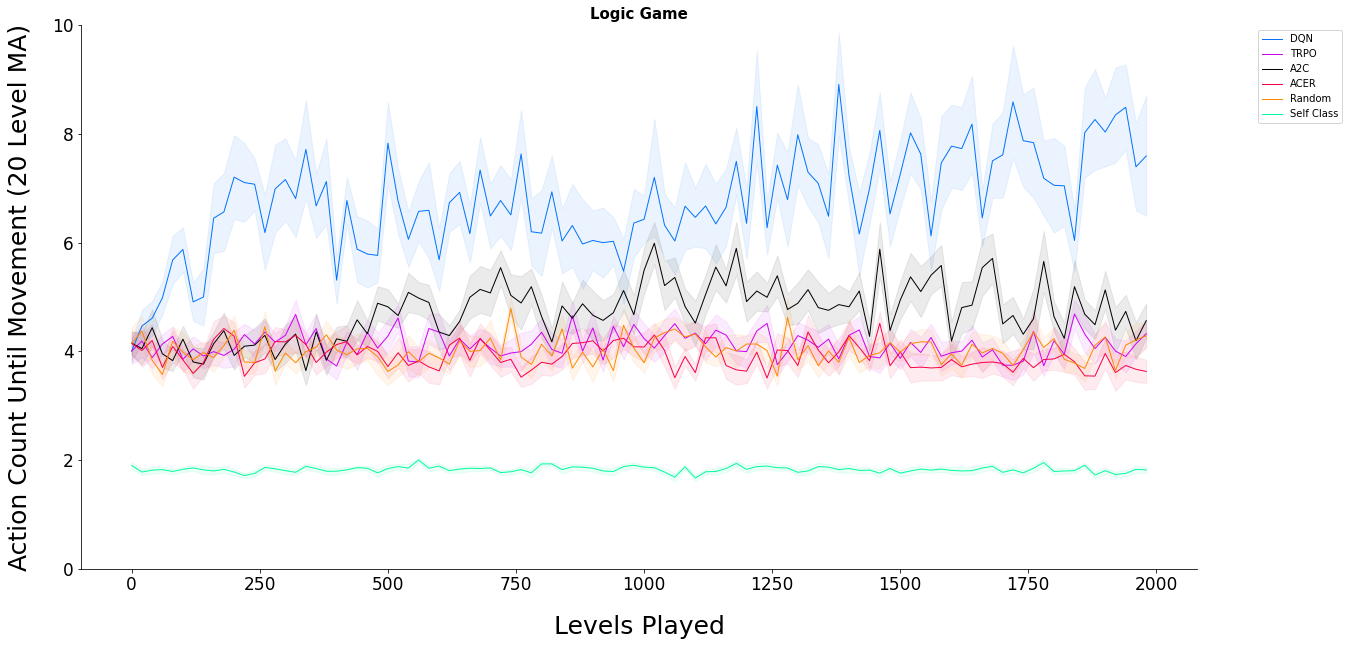

In [6]:
agent_types = ["dqn_training", "trpo_training", "a2c_training", "acer_training", "random", "self_class"]
game_types = ["logic_game"]
plot_nm_ac(game_types, agent_types)


In [ ]:
import statistics

# To subscript labels
def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

# Compare action counts of each seed for dqn
def plot_step_comparisons(game_type):
    
    x = np.random.randint(low=0, high=19, size=20)
    
    
    dqn_seed_counts = get_dqn_seeds(game_type)
    
    dqn_seed_avgs = {}
    
    # Find average step counts for each seed:
    for folder in dqn_seed_counts.keys():
        f = dqn_seed_counts[folder]
        
        seed_avgs = []
        for i, file in enumerate(f):
            seed = dqn_seed_counts[folder][i]
            seed_avgs.append(statistics.mean(seed))

        dqn_seed_avgs[folder] = seed_avgs
        
    labels = list(dqn_seed_avgs.keys())
    
    # Make legends readable
    for i, label in enumerate(labels):
        labels[i] = find_between(label, "_", "_ef") + label[-6:]
        

    fig, ax = plt.subplots(figsize=(20, 10))
    x = np.random.randint(low=0, high=19, size=20)
    y = np.random.randint(low=0, high=70, size=71)
    plt.xticks(np.arange(0, len(x)+1, 1))
    plt.yticks(np.arange(0, len(y)+1, 5))
    ax.set_xlabel(xlabel="x100 Levels", labelpad=21)
    ax.set_ylabel(ylabel="Average Action Count Of Each 100 Level", labelpad=21)
    ax.tick_params(axis='both', which='major', labelsize=17)
    ax.set_title( game_type, fontweight='bold', fontsize=15 )

    for i, avg in enumerate( list(dqn_seed_avgs.values()) ):
        ax.plot( avg, linewidth=2, label=labels[i], ls="-" )
    
    plt.legend(loc='best', numpoints=1)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    
    #for j, k in enumerate(list(dqn_seed_avgs.values())):
    #    for i, v in enumerate(list(dqn_seed_avgs.values())[j]):
    #        ax.text(i, v + 1, "%d" %v, ha="center")
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


    fname = game_type + "_dqn_ac.pdf"
    fig.savefig(fname, format='pdf')

# Get action counts of each seed
def get_dqn_seeds(game_type):
    agent_type = "dqn_training"
    files = glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")

    if len(files) == 0:
        files = glob.glob("../data/" + game_type + "/" + agent_type + "/*/*.json")


    directory_list = list()
    for root, dirs, files in os.walk(("../data/" + game_type + "/" + agent_type + "/"), topdown=False):
        for name in dirs:
            directory_list.append(os.path.join(root, name))
        
    seed_counts = {}
    for i, folder in enumerate(directory_list):
        files = glob.glob(folder + "/*.json")
        
        seeds = []
        for file in sorted(files, key=os.path.getmtime):
            data = json.load(open(file))
            steps = data.get("data")["steps"]

            if len(steps) == 0:
                continue
            
            seeds.append(steps)
        seed_counts[os.path.basename(folder)] = seeds

    return seed_counts


In [ ]:
plot_step_comparisons("test1_game")

In [ ]:
import statistics
import copy

# To subscript labels
def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

# Compare action counts of each seed for dqn
def plot_agents(game_type, agent_types):
    
    x = np.random.randint(low=0, high=19, size=20)
    
    dqn_seed_counts = get_agent_steps(game_type, agent_types)
    
    # TEMPORARY!
    for key in dqn_seed_counts.keys():
        items = dqn_seed_counts[key]
#        print("item: ", items)
        if len(items) > 1:
            #print("len>1")
            dqn_seed_counts[key] = dqn_seed_counts[key][2]
        else:
            dqn_seed_counts[key] = dqn_seed_counts[key][0]
    
    labels = agent_types
    
    print("DQN seed counts: ", dqn_seed_counts)

    fig, ax = plt.subplots(figsize=(20, 10))
    x = np.random.randint(low=0, high=19, size=20)
    y = np.random.randint(low=0, high=150, size=151)
    plt.xticks(np.arange(0, len(x)+1, 1))
    plt.yticks(np.arange(0, len(y)+1, 5))
    ax.set_xlabel(xlabel="x100 Levels", labelpad=21)
    ax.set_ylabel(ylabel="Average Action Count Of Each 100 Level", labelpad=21)
    ax.tick_params(axis='both', which='major', labelsize=17)
    title = "Comparison of Different RL Agents in {}".format(game_type)
    ax.set_title( title, fontweight='bold', fontsize=15 )

    for i, avg in enumerate( list(dqn_seed_counts.values()) ):
        print("avg: ", avg)
        ax.plot( avg, linewidth=2, label=labels[i], ls="-" )
    
    plt.legend(loc='best', numpoints=1)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    
    for j, k in enumerate(list(dqn_seed_counts.values())):
        for i, v in enumerate(list(dqn_seed_counts.values())[j]):
            ax.text(i, v + 1, "%d" %v, ha="center")
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


    fname = game_type + "_dqn_ac.pdf"
    fig.savefig(fname, format='pdf')
    

# Get action counts of each agent for each 100 level (avg. of each seed)
def get_agent_steps(game_type, agent_types):
    
    directories = {}
    
    for agent_type in agent_types:
        directory_list = list()
        for root, dirs, files in os.walk(("../data/" + game_type + "/" + agent_type + "/"), topdown=False):
            for name in dirs:
                directory_list.append(os.path.join(root, name))
        directories[agent_type] = copy.deepcopy(directory_list)

    
    
    print("Directories: ", directories)
    seed_counts = {}
    avg_seed_counts = {}
    
    for agent in agent_types:
        all_levels = [] # all levels in each seed
        directory_list = directories[agent]
        for i, folder in enumerate(directory_list): # iterate through each seed file and get all levels
            files = glob.glob(folder + "/*.json")

            avg_100 = []
            for file in sorted(files, key=os.path.getmtime):
                data = json.load(open(file))
                steps = data.get("data")["steps"]

                if len(steps) == 0:
                    continue
                    
                avg_steps = sum(steps) / len(steps)

                avg_100.append(avg_steps)
            #print("avg_100 for ", folder, ": ", avg_100)
            all_levels.append(avg_100)
            
        seed_avg = []
        
        # DO THIS AFTER RUNNING DQN AGAIN WITH GPU!
        if len(all_levels) > 1: # If there are more than one seeds tested, take avg of all seeds
            np_arr = np.array(all_levels)
            #seed_avg = np.mean(np_arr, axis=0)
#        print("Seed avg for ", agent, ": ", seed_avg)
            
        seed_counts[agent] = all_levels
        
    print("SEED COUNTS: ", seed_counts)

    
    return seed_counts



In [ ]:

agent_types = ["dqn_training", "a2c_training", "trpo_training", "self_class"]
plot_agents("logic_game", agent_types)